In [99]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import matplotlib.patches as patches
import jax.numpy as jnp 
import time
from jax import grad, hessian, jacfwd
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import fsolve
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['lines.linewidth'] = 2
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=18) 
mpl.rc('font', size=18) 

# disable LaTeX rendering
plt.rcParams['text.usetex'] = False

These are our four design variables of interest.

x1 = λr (x[...,0])
x2 = V0 (x[...,1])
x3 = D (x[...,2])
x4 = cl_cd (x[...,3])

In [100]:
# define wind power function
def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(x[0])*(x[0]+(1.32+((x[0]-8)/20)**2)/(beta**(2/3)))**-1-0.57*x[0]**2/((x[3])*((x[0])+0.5/beta))
    return (jnp.pi/8)*CP*rho*(x[1])**2*(x[2])**2

g = 9.81 # gravitational acceleration (m*s^-2)

# define constraints
c1 = lambda x: 0.883 - (4 * ( 1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232) * (1-(1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232)))
c2 = lambda x: 2.0 - 2 * x[0] * x[1] / x[2]
c3 = lambda x: 0.5 - 2 * x[1]**2 / (g * x[3]) 

bounds = Bounds([5.0, 0.0, 120.0, 25.0], [10.0, 22.0, 145.0, 100.0]) # design var. bounds

Please ignore the next 3 cells, as these were for our design space exploration. We decided to keep them in the code to highlight our work.

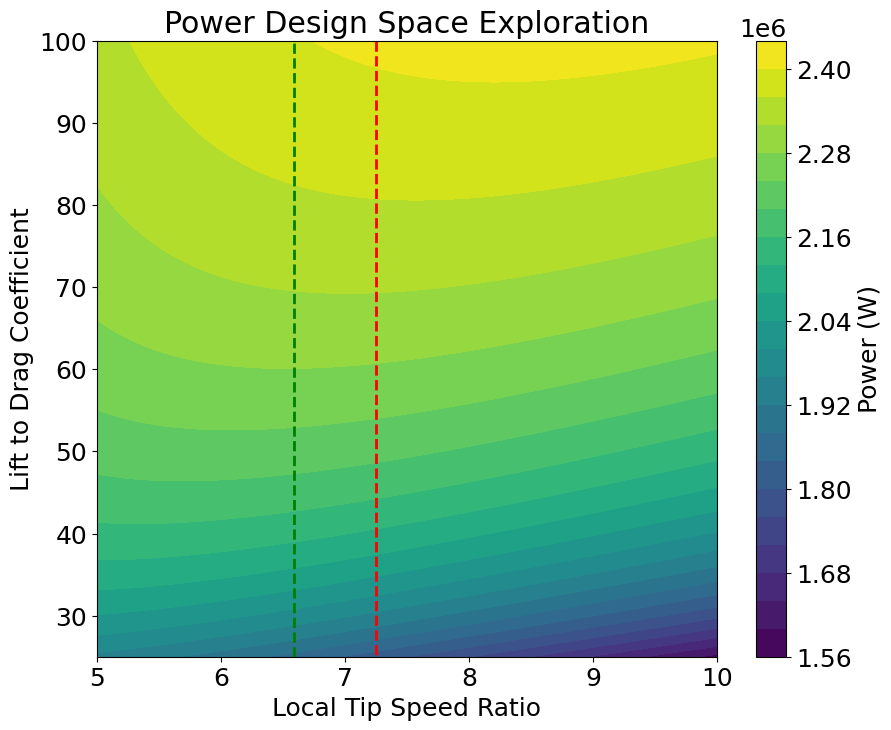

In [101]:
# let us fix x[1] (V0) and x[2] (D) at their max. bounded values
def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(x[...,0])*(x[...,0]+(1.32+((x[...,0]-8)/20)**2)/(beta**(2/3)))**-1-0.57*x[...,0]**2/((x[...,3])*((x[...,0])+0.5/beta))
    return (np.pi/8)*CP*rho*(22)**2*(145)**2

# create meshgrid 
x0_range = np.linspace(5.0, 10.0, 100)
x3_range = np.linspace(25.0, 100.0, 100)
X0, X3 = np.meshgrid(x0_range, x3_range)
X1 = 22
X2 = 145

X = np.stack((X0, np.full_like(X0, 22), np.full_like(X0, 145), X3), axis=-1)

# define constraints
c1 = lambda x: 0.883 - (4 * ( 1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232) * (1-(1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232)))
c2 = lambda x: 2.0 - 2 * x[0] * 22 / 145
c3 = lambda x: 0.5 - 2 * 22**2 / (g * x[3])

# create a contour plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(X0, X3, power(X),20, cmap='viridis')
plt.colorbar(contour, label='Power (W)')
plt.xlabel('Local Tip Speed Ratio')
plt.ylabel('Lift to Drag Coefficient')
plt.title('Power Design Space Exploration')

# plot constraints
plt.contour(X0, X3, c1([X0, X1, X2, X3]), levels=[0], colors='r', linestyles='--')
plt.contour(X0, X3, c2([X0, X1, X2, X3]), levels=[0], colors='g', linestyles='--')
plt.contour(X0, X3, c3([X0, X1, X2, X3]), levels=[0], colors='b', linestyles='--') # out of range anyways

# feasible region is right of red, left of green
plt.show()


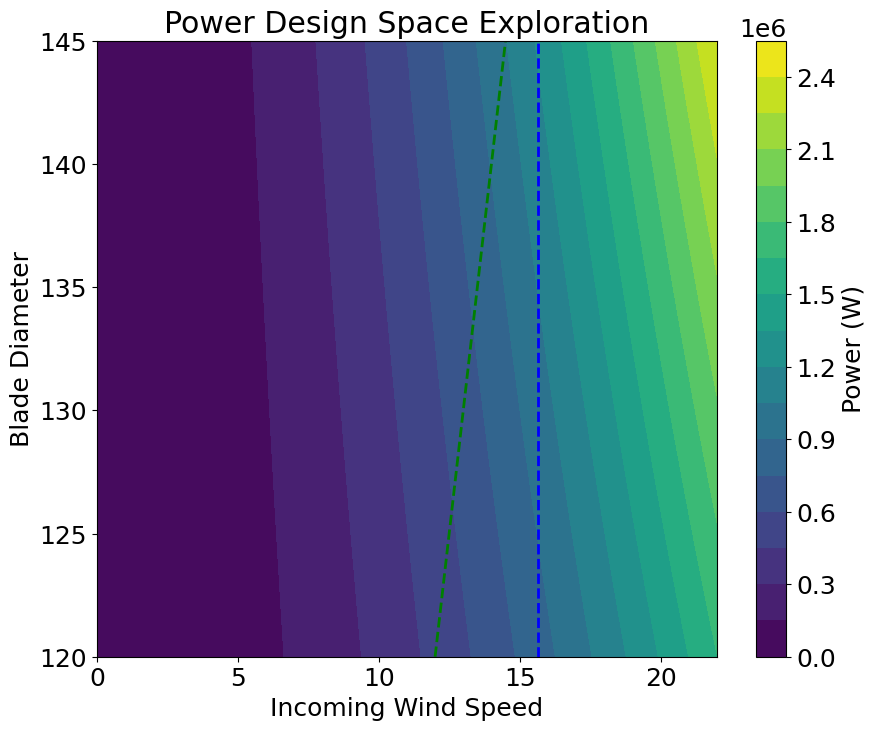

In [102]:
# let us fix x[0] (λr) and x[3] (cl/cd) at their max. bounded values
def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(10)*(10+(1.32+((10-8)/20)**2)/(beta**(2/3)))**-1-0.57*10**2/((100)*((10)+0.5/beta))
    return (jnp.pi/8)*CP*rho*(x[...,1])**2*(x[...,2])**2

# create meshgrid
x1_range = np.linspace(0.0, 22.0, 100)
x2_range = np.linspace(120.0, 145.0, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)

X = np.stack((np.full_like(X1, 10),X1, X2,np.full_like(X2, 100)), axis=-1)

# define constraints
c1 = lambda x: 0.883 - (4 * ( 1*10**-7 * 10**5 -6*10**-6 * 10**4 + 0.0001 * 10**3 - 0.001 * 10**2 + 0.0048 * 10 + 0.3232) * (1-(1*10**-7 * 10**5 -6*10**-6 * 10**4 + 0.0001 * 10**3 - 0.001 * 10**2 + 0.0048 * 10 + 0.3232)))
c2 = lambda x: 2.0 - 2 * 10 * x[1] / x[2]
c3 = lambda x: 0.5 - 2 * x[1]**2 / (g * 100)

# create a contour plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(X1, X2, power(X),20, cmap='viridis')
plt.colorbar(contour, label='Power (W)')
plt.xlabel('Incoming Wind Speed')
plt.ylabel('Blade Diameter')
plt.title('Power Design Space Exploration')


# plot constraints
#plt.contour(X1, X2, c1([X0, X1, X2, X3]), levels=[0], colors='r', linestyles='--') # only dependent on X0
plt.contour(X1, X2, c2([X0, X1, X2, X3]), levels=[0], colors='g', linestyles='--')
plt.contour(X1, X2, c3([X0, X1, X2, X3]), levels=[0], colors='b', linestyles='--') 

plt.show()


# feasible region is to left of green, right of blue (nothing is feasible)

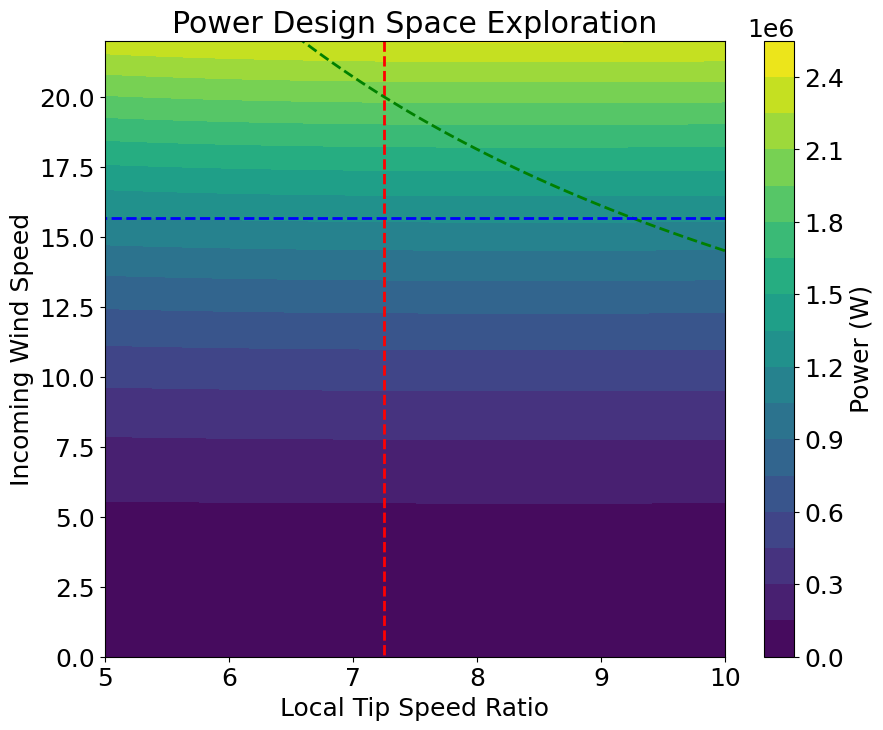

In [103]:
# let us fix x[2] (D) and x[3] (cl/cd) at their max. bounded values
def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(x[...,0])*(x[...,0]+(1.32+((x[...,0]-8)/20)**2)/(beta**(2/3)))**-1-0.57*x[...,0]**2/((100)*((x[...,0])+0.5/beta))
    return (jnp.pi/8)*CP*rho*(x[...,1])**2*(145)**2

# create meshgrid
x0_range = np.linspace(5.0, 10.0, 1000)
x1_range = np.linspace(0.0, 22.0, 1000)
X0, X1 = np.meshgrid(x0_range, x1_range)


X = np.stack((X0, X1, np.full_like(X0, 145), np.full_like(X1, 100)), axis=-1)

# define constraints
c1 = lambda x: 0.883 - (4 * ( 1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232) * (1-(1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232)))
c2 = lambda x: 2.0 - 2 * x[0] * x[1] / 145
c3 = lambda x: 0.5 - 2 * x[1]**2 / (g * 100)


# create contour plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(X0, X1, power(X),20, cmap='viridis')
plt.colorbar(contour, label='Power (W)')
plt.xlabel('Local Tip Speed Ratio')
plt.ylabel('Incoming Wind Speed')
plt.title('Power Design Space Exploration')


# plot constraints
plt.contour(X0, X1, c1([X0, X1, X2, X3]), levels=[0], colors='r', linestyles='--')
plt.contour(X0, X1, c2([X0, X1, X2, X3]), levels=[0], colors='g', linestyles='--')
plt.contour(X0, X1, c3([X0, X1, X2, X3]), levels=[0], colors='b', linestyles='--')

# feasible region is below blue, below green, and to right of red
plt.show()

# this ended up being our optimization problem, where blade diameter and cl/cd are maxed out to their upper bound constraint

In [104]:
# define constraints for SciPy minimize
def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(x[...,0])*(x[...,0]+(1.32+((x[...,0]-8)/20)**2)/(beta**(2/3)))**-1-0.57*x[...,0]**2/((x[...,3])*((x[...,0])+0.5/beta))
    return -1*(jnp.pi/8)*CP*rho*(x[...,1])**2*(x[...,2])**2

# define constraints
c1 = lambda x: 0.883 - (4 * ( 1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232) * (1-(1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232)))
c2 = lambda x: 2.0 - 2 * x[0] * x[1] / x[2]
c3 = lambda x: 0.5 - 2 * x[1]**2 / (g * x[3]) 

ineq_con1 = {'type': 'ineq',
             'fun': c1,
             'jac': grad(c1)}
ineq_con2 = {'type': 'ineq',
             'fun': c2,
             'jac': grad(c2)}
ineq_con3 = {'type': 'ineq',
             'fun': c3,
             'jac': grad(c3)}

k = 0

# define a callback function to store optimization histories
def callback_tr(x, state):
    global k
    k += 1
    
    xx_tr.append(x) # iterate xk
    fx_tr.append(-1*state.fun) # function value
    c1x_tr.append(ineq_con1['fun'](x)) # constraint evaluation for c1 only
    c2x_tr.append(ineq_con2['fun'](x))
    c3x_tr.append(ineq_con3['fun'](x))
    
    constraint_vec_tr = [c1(x), c2(x), c3(x)]
    constraint_history_tr.append(constraint_vec_tr)
    
    print(f'xk_tr {x}, fk_tr {-1*state.fun}, c1 {c1(x)}, c2 {c2(x)}, c3 {c3(x)}')
    
# starting point
x0 = np.array([5.0, 5.0, 120.0, 25.0])

xx_tr = [] 
fx_tr = []
c1x_tr = [] 
c2x_tr = [] 
c3x_tr = [] 
constraint_history_tr = []

start_time_tr = time.time()

res = minimize(power, x0, method='trust-constr', jac=None,
               constraints=[ineq_con1, ineq_con2, ineq_con3],
               options=None,
               bounds=bounds, callback=callback_tr)

end_time_tr = time.time()
print("total execution time for trust-region constrained:", end_time_tr - start_time_tr, "seconds")
print("optimization terminated successfully.")
print("current function value:", -1*res.fun)
print("iterations:", res.nit)
print("function evaluations:", res.nfev)
print("gradient evaluations:", res.njev)

# determining MCV 

MCV_tr = []

for constraint_vec_tr in constraint_history_tr:
    new_constraint_vec_tr = [
        max(0, -constraint_vec_tr[0]),  
        max(0, -constraint_vec_tr[1]),    
        max(0, -constraint_vec_tr[2])  
    ]
    c_inf_tr = np.linalg.norm(new_constraint_vec_tr, ord=np.inf)
    
    MCV_tr.append(c_inf_tr)

xk_tr [  5.   5. 120.  25.], fk_tr 68975.74142059393, c1 -0.0031106243749998708, c2 1.5833333333333333, c3 0.2961264016309888
xk_tr [  5.16396945   5.57710495 120.19943892  25.19620197], fk_tr 86018.54632070774, c1 -0.0030148797686974094, c2 1.5207964385654629, c3 0.24832299230681948
xk_tr [  4.98018095  10.60250071 120.44810019  25.4217446 ], fk_tr 313990.8009256805, c1 -0.0031208453503164257, c2 1.1232344557509601, c3 -0.40151354725078237
xk_tr [  5.07354901   9.63293294 120.72075275  26.08342566], fk_tr 261726.25904178864, c1 -0.0030701427402466397, c2 1.1903105933880302, c3 -0.22529291180792144
xk_tr [  4.94628364   9.20397896 121.47349412  27.71540099], fk_tr 246055.66728950047, c1 -0.003137648832283957, c2 1.2504456894547435, c3 -0.12314778631910461
xk_tr [  4.99836647   9.66410196 124.31345737  33.1081125 ], fk_tr 294999.90749032923, c1 -0.003111477858735223, c2 1.2228560887010187, c3 -0.07510821733421535
xk_tr [  5.11777546  10.21328925 127.42613298  38.86653347], fk_tr 356132.

xk_tr [  8.4104324   15.66045976 145.         100.        ], fk_tr 1222154.6257521366, c1 0.0033903936433415938, c2 0.18329326661206236, c3 1.3113066188452649e-11
xk_tr [  8.4104324   15.66045976 145.         100.        ], fk_tr 1222154.6257521366, c1 0.0033903936433415938, c2 0.18329326661206236, c3 1.3113066188452649e-11
xk_tr [  8.4104324   15.66045976 145.         100.        ], fk_tr 1222154.6257521366, c1 0.0033903936433415938, c2 0.18329326661206236, c3 1.3113066188452649e-11
xk_tr [  8.4104324   15.66045976 145.         100.        ], fk_tr 1222154.6257521366, c1 0.0033903936433415938, c2 0.18329326661206236, c3 1.3113066188452649e-11
xk_tr [  8.4104324   15.66045976 145.         100.        ], fk_tr 1222154.6257521366, c1 0.0033903936433415938, c2 0.18329326661206236, c3 1.3113066188452649e-11
xk_tr [  8.4104324   15.66045976 145.         100.        ], fk_tr 1222154.6257521366, c1 0.0033903936433415938, c2 0.18329326661206236, c3 1.3113066188452649e-11
xk_tr [  8.4104324   1

In [105]:
# COBYLA


ineq_con1 = {'type': 'ineq',
             'fun': c1,
             'jac': grad(c1)}
ineq_con2 = {'type': 'ineq',
             'fun': c2,
             'jac': grad(c2)}
ineq_con3 = {'type': 'ineq',
             'fun': c3,
             'jac': grad(c3)}

k_c = 0  
# define a callback function to store optimization histories
def callback_c(x):
    global k_c
    k_c += 1
    
    xx_c.append(x) # iterate xk
    fk_c_value = power(x)
    fx_c.append(-1*fk_c_value) # function value
    c1x_c.append(ineq_con1['fun'](x)) # constraint evaluation for c1 only
    c2x_c.append(ineq_con2['fun'](x))
    c3x_c.append(ineq_con3['fun'](x))
    
    constraint_vec_c = [c1(x), c2(x), c3(x)]
    constraint_history_c.append(constraint_vec_c)
    
    print(f'xk_c {x}, fk_c {-1*fk_c_value}, c1 {c1(x)}, c2 {c2(x)}, c3 {c3(x)}')

# starting point
x0 = np.array([5.0, 5.0, 120.0, 25.0])

xx_c = [] 
fx_c = []
c1x_c = [] 
c2x_c = [] 
c3x_c = [] 
constraint_history_c = []

constraints=[ineq_con1, ineq_con2, ineq_con3]


start_time_c = time.time()

res = minimize(power, x0, method='COBYLA', jac=None,
               constraints=constraints,
               options=None,
               bounds=bounds, callback=callback_c)  

end_time_c = time.time()
print("total execution time for COBYLA:", end_time_c - start_time_c, "seconds")
print("optimization terminated successfully.")
print("current function value:", -1*res.fun)
# print("iterations:", res.nit)
print("function evaluations:", res.nfev)
# print("gradient evaluations:", res.njev)

# determining MCV 

MCV_c = []

for constraint_vec_c in constraint_history_c:
    new_constraint_vec_c = [
        max(0, -constraint_vec_c[0]),  
        max(0, -constraint_vec_c[1]),  
        max(0, -constraint_vec_c[2])
    ]
    
    c_inf_c = np.linalg.norm(new_constraint_vec_c, ord=np.inf)
    
    MCV_c.append(c_inf_c)    

xk_c [  6.   5. 120.  25.], fk_c 67307.16215438627, c1 -0.002216728309759941, c2 1.5, c3 0.2961264016309888
xk_c [  5.   6. 120.  25.], fk_c 99325.06764565528, c1 -0.0031106243749998708, c2 1.5, c3 0.20642201834862384
xk_c [  5.   6. 121.  25.], fk_c 100987.3830138916, c1 -0.0031106243749998708, c2 1.5041322314049586, c3 0.20642201834862384
xk_c [  5.   6. 121.  26.], fk_c 102046.17688841709, c1 -0.0031106243749998708, c2 1.5041322314049586, c3 0.21771347918136907
xk_c [  6.   6. 121.  26.], fk_c 99825.13318086298, c1 -0.002216728309759941, c2 1.4049586776859504, c3 0.21771347918136907
xk_c [  7.   6. 121.  26.], fk_c 96704.02531871706, c1 -0.0005480279996398219, c2 1.3057851239669422, c3 0.21771347918136907
xk_c [  6.89827186   6.99107706 121.0568774   26.06467302], fk_c 132011.62793691352, c1 -0.0007560903123905449, c2 1.2032447691092725, c3 0.11770652453365832
xk_c [  7.27070332   7.90427461 121.09999493  25.90496727], fk_c 166193.4945328117, c1 5.1288246118885716e-05, c2 1.05087302

In [106]:
# SLSQP

k_slsqp = 0  
# define a callback function to store optimization histories
def callback_slsqp(x):
    global k_slsqp
    k_slsqp += 1
    
    xx_slsqp.append(x) # iterate xk
    fk_slsqp_value = power(x)
    fx_slsqp.append(-1*fk_slsqp_value) # function value
    c1x_slsqp.append(ineq_con1['fun'](x)) 
    c2x_slsqp.append(ineq_con2['fun'](x))
    c3x_slsqp.append(ineq_con3['fun'](x))
    
    constraint_vec_slsqp = [c1(x), c2(x), c3(x)]
    constraint_history_slsqp.append(constraint_vec_slsqp)
    
    print(f'k_s {k_slsqp}, xk_slsqp {x}, fk_slsqp {-1*fk_slsqp_value}, c1 {c1(x)}, c2 {c2(x)}, c3 {c3(x)}')


x0 = np.array([5.0, 5.0, 120.0, 25.0])

xx_slsqp = [] 
fx_slsqp = []
c1x_slsqp = [] 
c2x_slsqp = [] 
c3x_slsqp = [] 
constraint_history_slsqp = []
constraints=[ineq_con1, ineq_con2, ineq_con3]

start_time_slsqp = time.time()

res = minimize(power, x0, method='SLSQP', jac=None,
               constraints=constraints,
               options=None,
               bounds=bounds, callback=callback_slsqp)

end_time_slsqp = time.time()
print("total execution time for SLSQP:", end_time_slsqp - start_time_slsqp, "seconds")
print("optimization terminated successfully.")
print("current function value:", -1*res.fun)
print("iterations:", res.nit)
print("function evaluations:", res.nfev)
print("gradient evaluations:", res.njev)


# determining MCV

MCV_slsqp = []

for constraint_vec_slsqp in constraint_history_slsqp:
    new_constraint_vec_slsqp = [
        max(0, -constraint_vec_slsqp[0]),  
        max(0, -constraint_vec_slsqp[1]),  
        max(0, -constraint_vec_slsqp[2])
    ]
    
    c_inf_slsqp = np.linalg.norm(new_constraint_vec_slsqp, ord=np.inf)
    
    MCV_slsqp.append(c_inf_slsqp)

k_s 1, xk_slsqp [  6.49320817  16.13448793 145.         100.        ], fk_slsqp 1288624.6818387723, c1 -0.0014961477128010436, c2 0.5549711887563691, c3 -0.030727218947331658
k_s 2, xk_slsqp [ 10.  22. 145. 100.], fk_slsqp 2404418.2452234374, c1 0.010877759999999959, c2 -1.0344827586206895, c3 -0.48674821610601426
k_s 3, xk_slsqp [ 10.  22. 145. 100.], fk_slsqp 2404418.2452234374, c1 0.010877759999999959, c2 -1.0344827586206895, c3 -0.48674821610601426
k_s 4, xk_slsqp [  9.20270173  16.14985788 145.         100.        ], fk_slsqp 1298651.2717204164, c1 0.006640732887883138, c2 -0.04996310355944944, c3 -0.031738857123422615
k_s 5, xk_slsqp [  8.27011726  16.11717369 145.         100.        ], fk_slsqp 1294441.4532012672, c1 0.0029007336702375763, c2 0.1615046027380329, c3 -0.02958876200490501
k_s 6, xk_slsqp [  9.22459868  16.46306601 145.         100.        ], fk_slsqp 1349450.949284045, c1 0.006743264185390507, c2 -0.09469209592058414, c3 -0.05256379684723955
k_s 7, xk_slsqp [  9.2

In [107]:
# Optimization Trajectory
'''
plt.figure(figsize=(10, 8))
contour = plt.contour(X0, X1, -1*power(X), 25, cmap='viridis')
plt.colorbar(contour, label='Power (W)')

# plot trust-region algorithm
x1_tr = [x[0] for x in xx_tr]
x2_tr = [x[1] for x in xx_tr]

# plot COBYLA algorithm
x1_c = [x[0] for x in xx_c]
x2_c = [x[1] for x in xx_c]

# plot SLSQP algorithm
x1_slsqp = [x[0] for x in xx_slsqp]
x2_slsqp = [x[1] for x in xx_slsqp]


plt.plot(x1_tr, x2_tr, marker='o', c='#a11b03', label='Trust-Region Constrained')
plt.plot(x1_c, x2_c, marker='o', c='#03a15d', label='COBYLA')
plt.plot(x1_slsqp, x2_slsqp, marker='o', c='#1c1d6b', label='SLSQP')


plt.xlabel('Local Tip Speed Ratio')
plt.ylabel('Incoming Wind Speed')
plt.title('Optimization Trajectory')
plt.xlim(5.0, 10.0)  
plt.ylim(0, 22.0)
plt.legend()
plt.show()
'''

# we decided against showing the opt trajectory, as it did not make sense with the dimensions we were working with

"\nplt.figure(figsize=(10, 8))\ncontour = plt.contour(X0, X1, -1*power(X), 25, cmap='viridis')\nplt.colorbar(contour, label='Power (W)')\n\n# plot trust-region algorithm\nx1_tr = [x[0] for x in xx_tr]\nx2_tr = [x[1] for x in xx_tr]\n\n# plot COBYLA algorithm\nx1_c = [x[0] for x in xx_c]\nx2_c = [x[1] for x in xx_c]\n\n# plot SLSQP algorithm\nx1_slsqp = [x[0] for x in xx_slsqp]\nx2_slsqp = [x[1] for x in xx_slsqp]\n\n\nplt.plot(x1_tr, x2_tr, marker='o', c='#a11b03', label='Trust-Region Constrained')\nplt.plot(x1_c, x2_c, marker='o', c='#03a15d', label='COBYLA')\nplt.plot(x1_slsqp, x2_slsqp, marker='o', c='#1c1d6b', label='SLSQP')\n\n\nplt.xlabel('Local Tip Speed Ratio')\nplt.ylabel('Incoming Wind Speed')\nplt.title('Optimization Trajectory')\nplt.xlim(5.0, 10.0)  \nplt.ylim(0, 22.0)\nplt.legend()\nplt.show()\n"

<Figure size 1000x800 with 0 Axes>

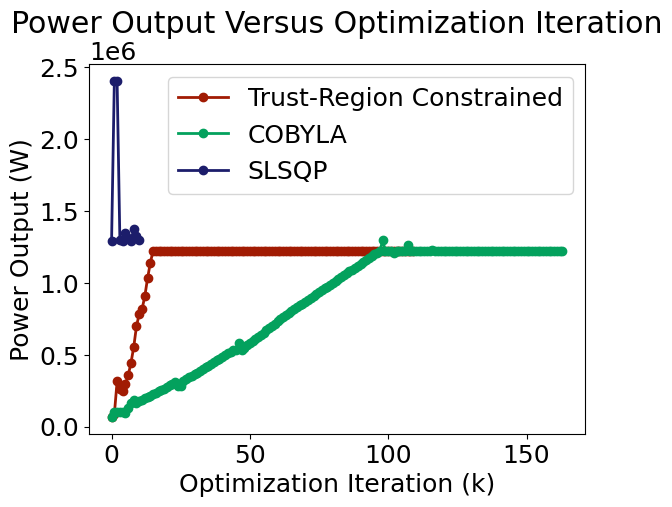

In [108]:
# Function Value vs. Optimization Iteration

plt.figure(figsize=(10, 8))
plt.figure()
plt.plot(range(len(fx_tr)), fx_tr, marker='o',c='#a11b03', label='Trust-Region Constrained')
plt.plot(range(len(fx_c)), fx_c, marker='o',c='#03a15d', label='COBYLA')
plt.plot(range(len(fx_slsqp)), fx_slsqp, marker='o',c='#1c1d6b', label='SLSQP')
plt.xlabel('Optimization Iteration (k)')
plt.ylabel('Power Output (W)')
plt.title('Power Output Versus Optimization Iteration')
plt.legend()
plt.show()



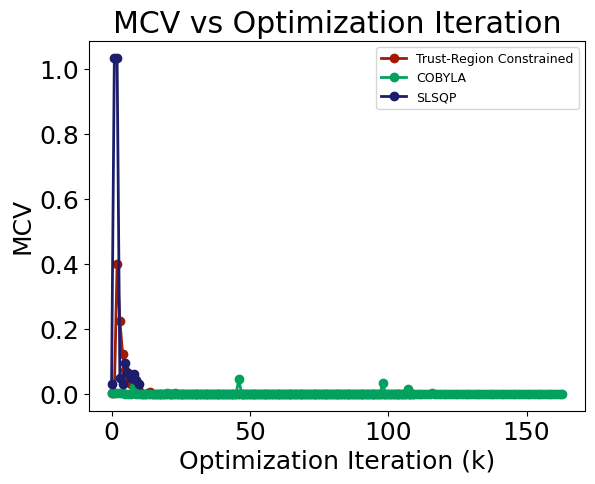

last value of MCV_tr: 0.0
last value of MCV_c: 0.0
last value of MCV_slsqp: 0.03185117640605828


In [109]:
# Maximum Constraint Violation

plt.plot(range(len(c1x_tr)), MCV_tr, marker='o',c='#a11b03', label='Trust-Region Constrained')
plt.plot(range(len(c1x_c)), MCV_c, marker='o',c='#03a15d', label='COBYLA')
plt.plot(range(len(c1x_slsqp)), MCV_slsqp, marker='o',c='#1c1d6b', label='SLSQP')
plt.xlabel('Optimization Iteration (k)')
plt.ylabel('MCV')
plt.title('MCV vs Optimization Iteration')
plt.legend(fontsize='9')
plt.show()

# print final MCV value for each iteration

print("last value of MCV_tr:", MCV_tr[-1])
print("last value of MCV_c:", MCV_c[-1])
print("last value of MCV_slsqp:", MCV_slsqp[-1])

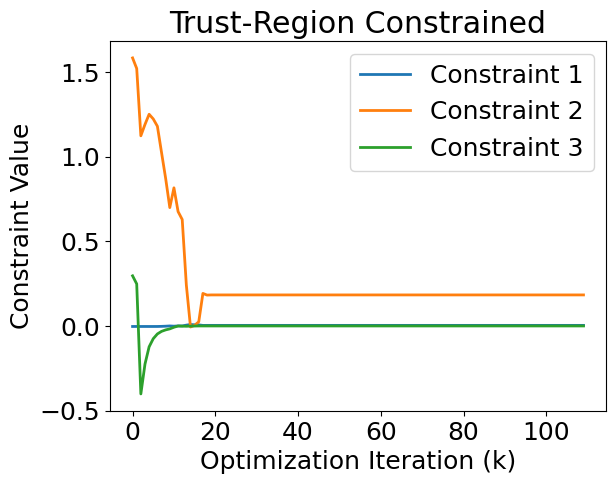

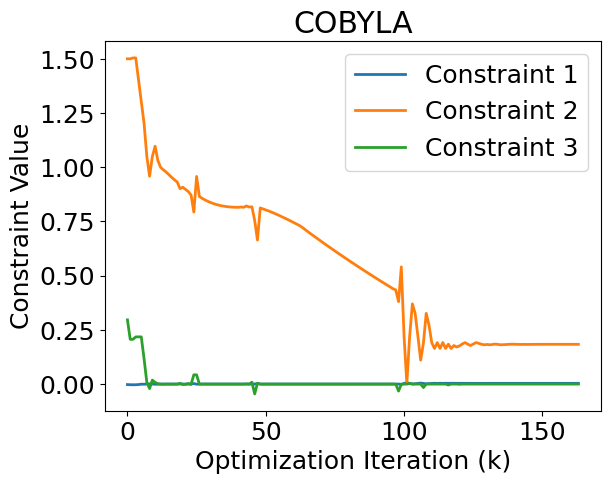

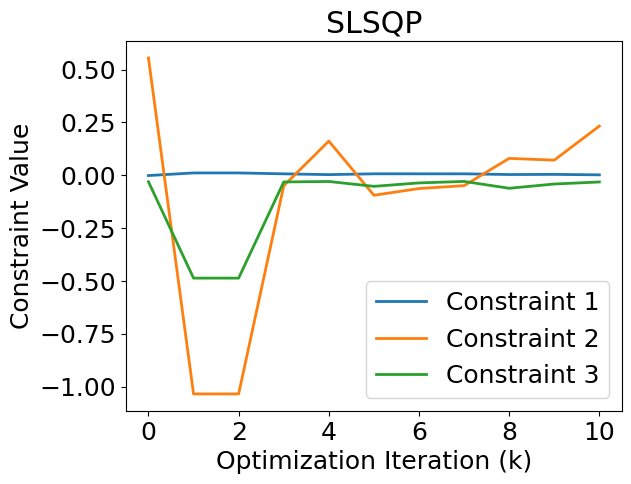

In [110]:
# constraint history

# Trust-Region Constrained
plt.figure()
plt.plot(range(len(c1x_tr)), c1x_tr, label='Constraint 1')
plt.plot(range(len(c2x_tr)), c2x_tr, label='Constraint 2')
plt.plot(range(len(c3x_tr)), c3x_tr, label='Constraint 3')
plt.xlabel('Optimization Iteration (k)')
plt.ylabel('Constraint Value')
plt.title('Trust-Region Constrained')
plt.legend()
plt.show()

# COBYLA
plt.figure()
plt.plot(range(len(c1x_c)), c1x_c, label='Constraint 1')
plt.plot(range(len(c2x_c)), c2x_c, label='Constraint 2')
plt.plot(range(len(c3x_c)), c3x_c, label='Constraint 3')
plt.xlabel('Optimization Iteration (k)')
plt.ylabel('Constraint Value')
plt.title('COBYLA')
plt.legend()
plt.show()

# SLSQP
plt.figure()
plt.plot(range(len(c1x_slsqp)), c1x_slsqp, label='Constraint 1')
plt.plot(range(len(c2x_slsqp)), c2x_slsqp, label='Constraint 2')
plt.plot(range(len(c3x_slsqp)), c3x_slsqp, label='Constraint 3')
plt.xlabel('Optimization Iteration (k)')
plt.ylabel('Constraint Value')
plt.title('SLSQP')
plt.legend()
plt.show()

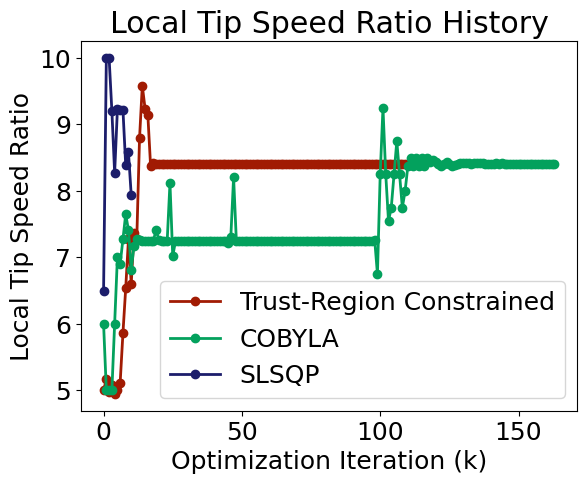

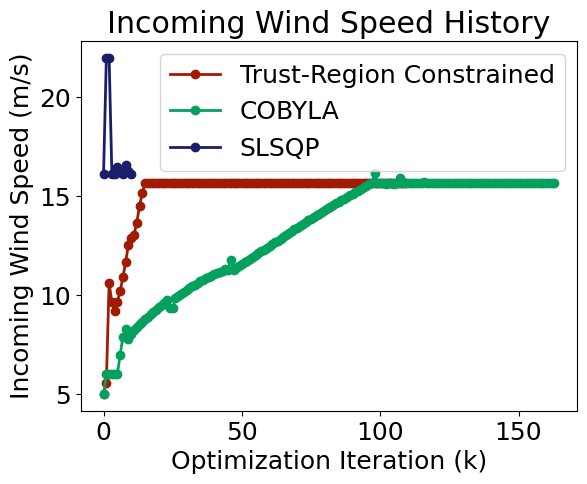

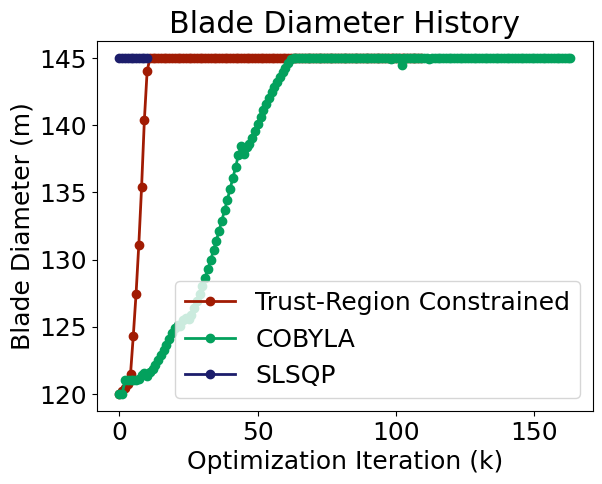

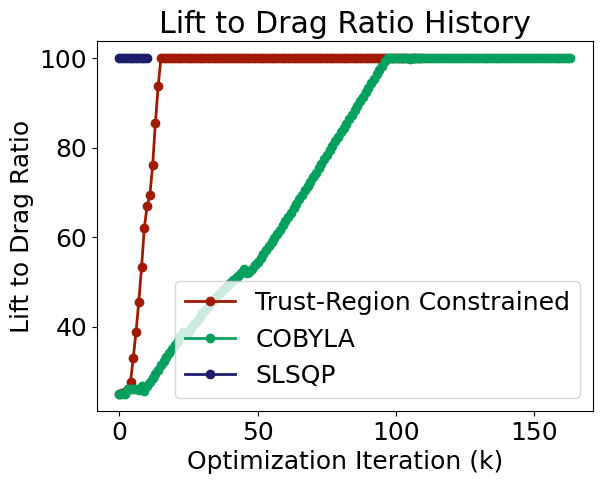

In [111]:
# Local Tip Speed Ratio History
plt.figure()
plt.plot(range(len(xx_tr)), [x[0] for x in xx_tr], marker='o',c='#a11b03', label='Trust-Region Constrained')
plt.plot(range(len(xx_c)), [x[0] for x in xx_c], marker='o',c='#03a15d', label='COBYLA')
plt.plot(range(len(xx_slsqp)), [x[0] for x in xx_slsqp], marker='o',c='#1c1d6b', label='SLSQP')
plt.xlabel('Optimization Iteration (k)')
plt.ylabel('Local Tip Speed Ratio')
plt.title('Local Tip Speed Ratio History')
plt.legend()
plt.show()

# Incoming Wind Speed History
plt.figure()
plt.plot(range(len(xx_tr)), [x[1] for x in xx_tr], marker='o',c='#a11b03', label='Trust-Region Constrained')
plt.plot(range(len(xx_c)), [x[1] for x in xx_c], marker='o',c='#03a15d', label='COBYLA')
plt.plot(range(len(xx_slsqp)), [x[1] for x in xx_slsqp], marker='o',c='#1c1d6b', label='SLSQP')
plt.xlabel('Optimization Iteration (k)')
plt.ylabel('Incoming Wind Speed (m/s)')
plt.title('Incoming Wind Speed History')
plt.legend()
plt.show()

# Blade Diameter History
plt.figure()
plt.plot(range(len(xx_tr)), [x[2] for x in xx_tr], marker='o',c='#a11b03', label='Trust-Region Constrained')
plt.plot(range(len(xx_c)), [x[2] for x in xx_c], marker='o',c='#03a15d', label='COBYLA')
plt.plot(range(len(xx_slsqp)), [x[2] for x in xx_slsqp], marker='o',c='#1c1d6b', label='SLSQP')
plt.xlabel('Optimization Iteration (k)')
plt.ylabel('Blade Diameter (m)')
plt.title('Blade Diameter History')
plt.legend()
plt.show()

# Lift to Drag Ratio History
plt.figure()
plt.plot(range(len(xx_tr)), [x[3] for x in xx_tr], marker='o',c='#a11b03', label='Trust-Region Constrained')
plt.plot(range(len(xx_c)), [x[3] for x in xx_c], marker='o',c='#03a15d', label='COBYLA')
plt.plot(range(len(xx_slsqp)), [x[3] for x in xx_slsqp], marker='o',c='#1c1d6b', label='SLSQP')
plt.xlabel('Optimization Iteration (k)')
plt.ylabel('Lift to Drag Ratio')
plt.title('Lift to Drag Ratio History')
plt.legend()
plt.show()